## Bioinstrumentation LGBIO2020
#### Marc Phillipe Marburger
#### Tomás dos Santos Talento

In [3]:
## all of the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy.signal import butter, filtfilt, iirnotch
from scipy.signal import welch
from scipy.integrate import simpson as simps

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# global variables
fs = 1024

In [5]:
# import datasets
channels = pd.read_csv("Data\channel_names.csv", names = ['names'])
eyes_closed = pd.read_csv("Data\data_closed.csv", header=None).transpose()
eyes_open = pd.read_csv("Data\data_open.csv", header=None).transpose()

new_names = channels['names'].to_list()
eyes_closed.rename(columns=dict(zip(eyes_closed.columns, new_names)), inplace=True)
eyes_open.rename(columns=dict(zip(eyes_open.columns, new_names)), inplace=True)

fs = 1024

#inserting a time column
size = len(eyes_closed)
time_vector = np.linspace(0, size/fs, size, endpoint=False)
eyes_closed.insert(loc=0, column='time', value=time_vector)

size = len(eyes_open)
time_vector = np.linspace(0, size/fs, size, endpoint=False)
eyes_open.insert(loc=0, column='time', value=time_vector)

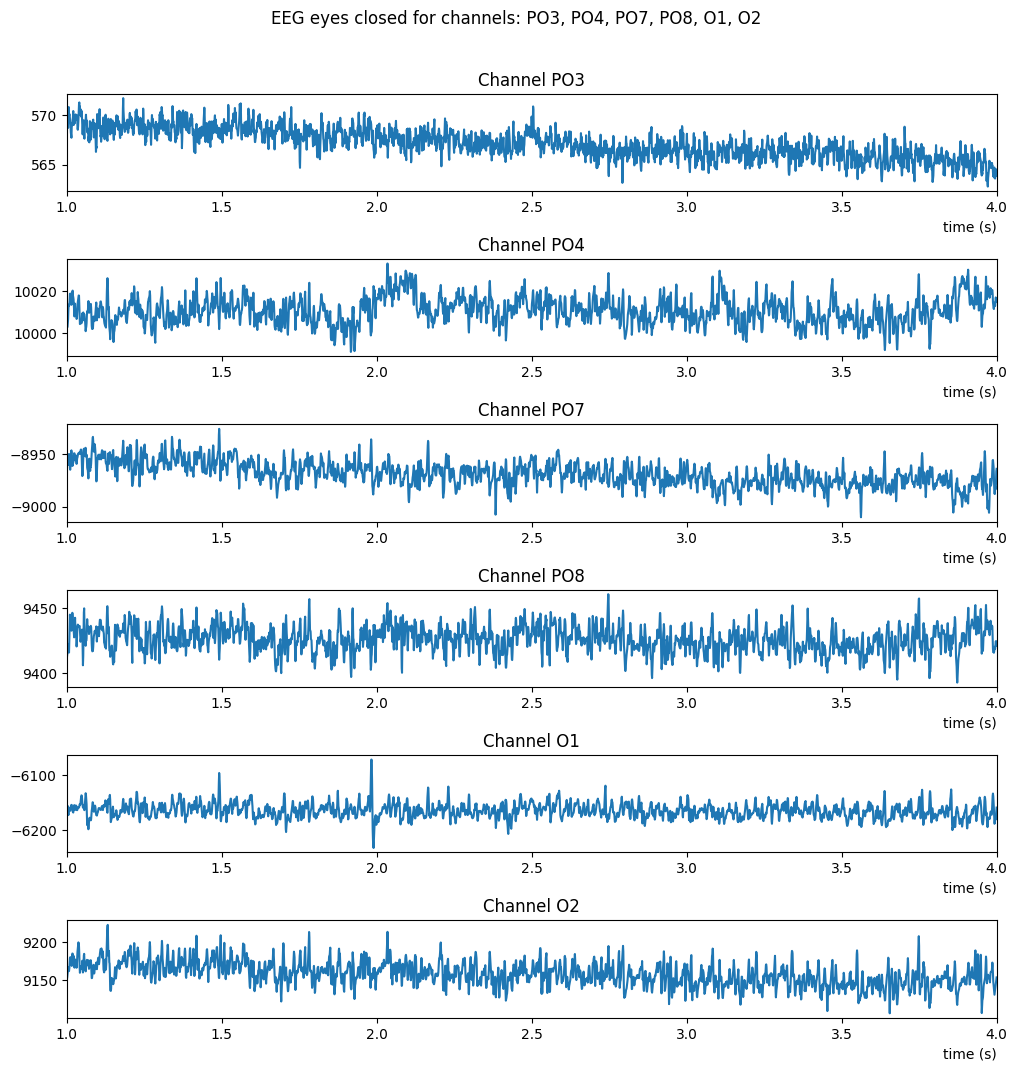

In [6]:
# Skip this
# function to display the requested channels within a specified time interval
def disp(chs=['Fp1', 'Fp2'], data=eyes_closed, interval=[1,6], title='EEG eyes closed'):
    
    fig, axes = plt.subplots(len(chs), 1, figsize=(12, 2*len(chs)))

    if len(chs)<64:
        fig.suptitle(f"{title} for channels: " + ', '.join(f'{ch}' for ch in chs), y=0.95)
    else:
        fig.suptitle(f"{title} for all channels", y=0.95)

    for i in range(len(chs)):
        axes[i].plot(data['time'].loc[interval[0]*fs:interval[1]*fs], data[chs[i]].loc[interval[0]*fs:interval[1]*fs])
        axes[i].set_title(f'Channel {chs[i]}')
        axes[i].set_xlim(interval)
        axes[i].set_xlabel('time (s)', loc='right')
    
    plt.subplots_adjust(hspace=0.7)
    #plt.tight_layout()
    plt.show()


disp(chs=["PO3", "PO4", "PO7", "PO8", "O1", "O2"], interval=[1,4])

<font size=5 color=#009999> <b>PREPROCESSING </b> <br>
FILTER LOW FREQUENCY ARTEFACT AND POWER LINE NOISE
</font> <br> <br>

In [7]:
# function to filter one eeg channel with a double butterworth filter + notch filter
def filter_eeg(signal, sampling_rate=fs):
    # parameters
    order = 4
    nyquist = sampling_rate/2
    low_cutoff = 0.5
    high_cutoff = 40

    # filtering with a butterworth (no ripples) forward and backwards (no phase shift) 
    b, a = butter(order, [low_cutoff/nyquist, high_cutoff/nyquist], btype='band')
    filtered_signal = filtfilt(b, a, signal)

    # filtering the signal again with a notch to get rid of the 50 Hz  powerline interference
    b, a = iirnotch(50, 40, fs)
    filtered_signal = filtfilt(b, a, filtered_signal)

    return filtered_signal

In [8]:
# Preprocessing
eyes_closed_filtered = eyes_closed.copy()
eyes_open_filtered = eyes_open.copy()

for channel in eyes_closed_filtered.columns[1:]:
    eeg_series = np.array(eyes_closed_filtered[channel])

    # subtract mean to each of the channels
    channel_mean = np.mean(eeg_series)
    eeg_series -= channel_mean

    #filtering
    eeg_series = filter_eeg(eeg_series)

    # rescaling by standard deviation
    channel_std = np.std(eeg_series)
    eeg_series /= channel_std

    eyes_closed_filtered[channel] = eeg_series

for channel in eyes_open_filtered.columns[1:]:
    eeg_series = np.array(eyes_open_filtered[channel])

    # subtract mean to each of the channels
    channel_mean = np.mean(eeg_series)
    eeg_series -= channel_mean

    #filtering
    eeg_series = filter_eeg(eeg_series)

    # rescaling by standard deviation
    channel_std = np.std(eeg_series)
    eeg_series /= channel_std

    eyes_open_filtered[channel] = eeg_series

# remove first and last 0.5 seconds to remove any artifaacts from filtering in the begining and at the end of the signal
eyes_closed_filtered = eyes_closed_filtered.iloc[512:-512]
eyes_open_filtered = eyes_open_filtered.iloc[512:-512]



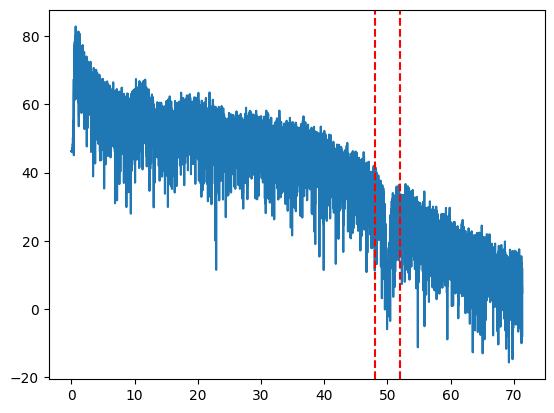

In [9]:
# Skip this
# displaying the dft of a channel to see the effects of filtering
p = eyes_closed_filtered.iloc[:,1]

# dft
dft = np.fft.fft(p,axis=0)
w = np.fft.fftfreq(dft.shape[0],1/fs)
w = np.fft.fftshift(w)
dft = np.fft.fftshift(dft)
dft = 20*np.log10(abs(dft))

plt.plot(w[61440:70000], dft[61440:70000])
plt.axvline(x=48, color='r', linestyle='--')
plt.axvline(x=52, color='r', linestyle='--')
plt.show()


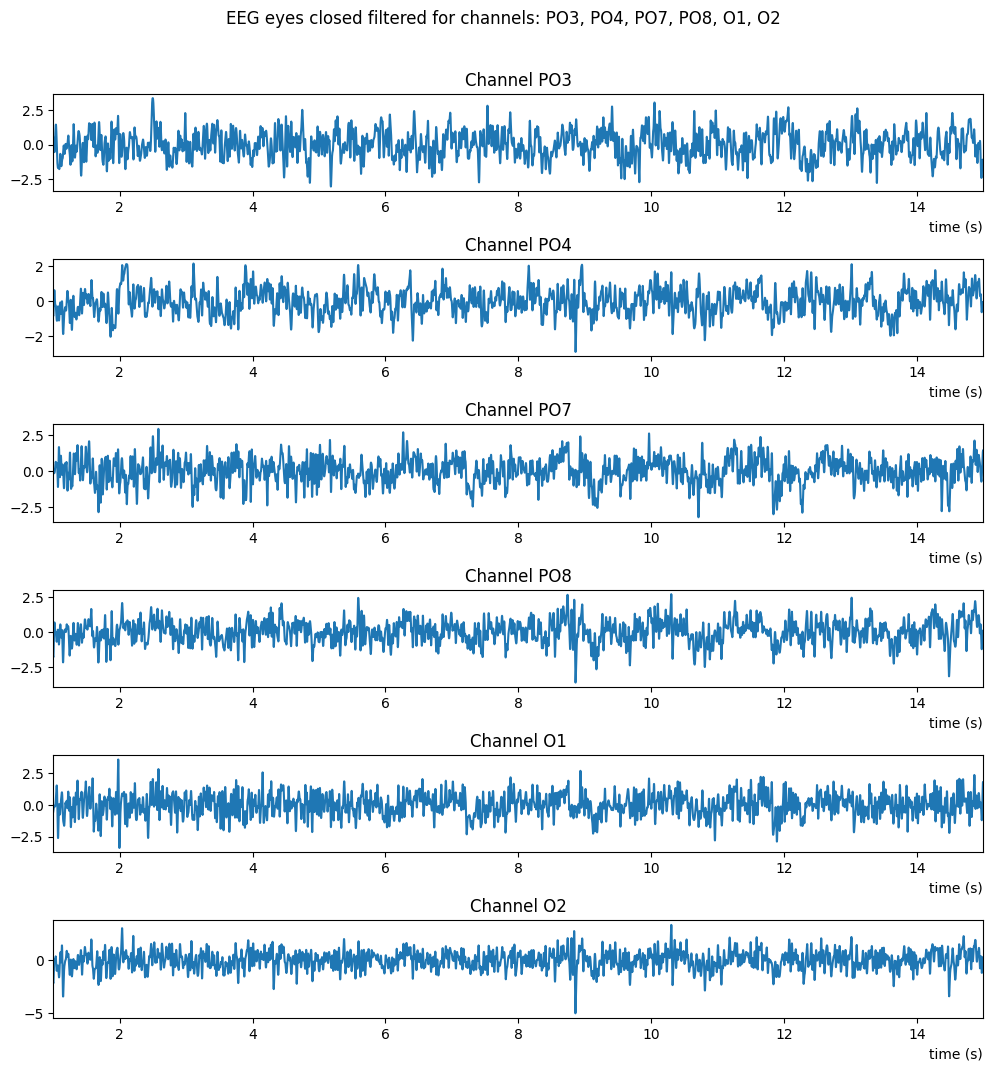

In [10]:
# Skip this
# displaying all the channels after filtering. Warning big plot
disp(chs=["PO3", "PO4", "PO7", "PO8", "O1", "O2"], data=eyes_closed_filtered, interval=[1,15], title = "EEG eyes closed filtered")

<font size=5 color=#009999> <b> CONSTRUCT YOUR TRAINING SAMPLES </b> <br>
DIVIDE THE SIGNALS INTO SHORT SEGMENTS
</font> <br> <br>

In [15]:
# Data segmentation: creating a dictionary of dataframes (one per channel) with the segments for each channel
data_segmented = {key: None for key in eyes_closed_filtered.columns[1:]}

# overlap parameter controls how much a segment overlaps with the previous one in percentage
overlap = 0.5
# computing the number of segments possible from the number of samples and the requested overlap
# segement_num = 1st segment + (Num_samples without the 1st segment)/(length of 1 segment * (1-overlap))
num_of_segments_eyes_closed = np.floor(1 + (len(eyes_closed_filtered) - 0.5*fs)/((1-overlap)*0.5*fs)).astype(int)
num_of_segments_eyes_open = np.floor(1 + (len(eyes_open_filtered) - 0.5*fs)/((1-overlap)*0.5*fs)).astype(int)
# By flooring the number of segments we are not using the last segment of the signal

for channel in data_segmented:
    data = pd.DataFrame(columns=[f'{i}' for i in range(int(0.5*fs))]+['label']) # creating a dataframe to store the segments of the channel
    idx = 0

    # add eyes closed segments
    for segement in range(num_of_segments_eyes_closed): 
        # For each channel, iterates through the segments (based on the calculated number of segments for eyes closed condition).
        # sample range for segment i = i
        new_segment = eyes_closed_filtered[channel][int(segement*0.5*(1-overlap)*fs):int((segement*0.5*(1-overlap)+0.5)*fs)].to_list() + [1]
        # segment is extracted based on the calculated indices, ensuring proper overlap between segments.
        # Each segment is then converted to a list and appended with a label (here, '1' representing eyes closed condition).
        data.loc[idx] = new_segment # Appending the segment to the dataframe.
        idx += 1

    # add eyes open segments
    for segement in range(num_of_segments_eyes_open):
        new_segment = eyes_open_filtered[channel][int(segement*0.5*(1-overlap)*fs):int((segement*0.5*(1-overlap)+0.5)*fs)].to_list() + [0]
        data.loc[idx] = new_segment
        idx += 1
    
    # add the labels to the datasets
    data['label'] = data['label'].astype(int)
    data_segmented[channel] = data # End size is (1030,513), where 1030 is the number of segments and 513 is the number of samples per segment. 
    # Each segment has 512 samples and a label (0 or 1). 479 segments are from eyes closed condition and 551 segments are from eyes open condition.
    

In [16]:
# Skip this
# function to display the segments and their dft for analysis purposes
def disp_segment(channel='Fp1', num=10):
    channel_data = data_segmented['Fp1']
    segement = np.array(channel_data.iloc[num][:-1])
    time = np.linspace(0, 0.5, int(fs/2), endpoint=False)
    label = data_segmented[channel]['label'][num]

    #compute the dft with interpolation just for better quality of the plot
    interpolation_factor = 10
    dft_signal = np.zeros(int(0.5*fs*interpolation_factor))
    dft_signal[:int(0.5*fs)] = segement

    dft = np.fft.fft(dft_signal, axis=0)
    w = np.fft.fftfreq(dft.shape[0], 1/fs)
    w = np.fft.fftshift(w)
    dft = np.fft.fftshift(dft)
    dft = abs(dft)  

    # figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"EEG with {'CLOSED' if label == 1 else 'OPEN'} eyes || Channel {channel}, Segment {num}")
    axes[0].plot(time, segement)
    axes[0].set_xlabel('time (s)')
    axes[0].set_title("Signal")
    axes[1].plot(w[int(0.5*len(dft_signal)):int(0.56*len(dft_signal))], dft[int(0.5*len(dft_signal)):int(0.56*len(dft_signal))])
    axes[1].set_xlabel('freqency (Hz)')
    axes[1].set_title("DFT")
    plt.show()

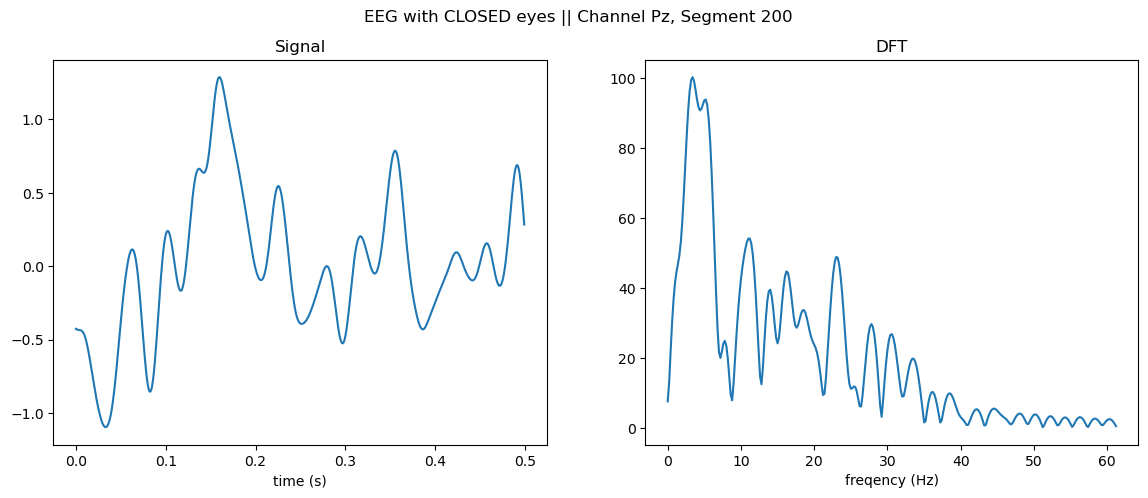

In [17]:
# Skip this
disp_segment(channel='Pz', num = 200)
#disp_segment(num = 12)

<br><br>

<font size=6 color=#009999> <center><b>PART II - FEATURE GENERATION </b></center> </font> <br> <br>

<font size=5 color=#009999> <b>CREATE YOUR OWN FEATURE SPACE </b> <br>
WHAT CAN BE CONSIDERED?
</font> <br> <br>

In [19]:
# getBandPower function

# -------------------------------------------------------------------------------------
# Provide the PSD of a signal for several frequency bands 
# Inspired from the tutorial : https://raphaelvallat.com/bandpower.html
# Inputs : 
#   - signal : a 1-D signal 
#   - fs : sampling frequency of the signal
# Outputs: 
#   - PSD : a list of the PSD evaluated in the specified frequency bands
#   - rangeName : a list describing the frequency bands
# -------------------------------------------------------------------------------------

def getBandPower(signal, fs): 
    freqs, psd  = welch(signal, fs, nfft = 8192)
    freq_res    = freqs[1] - freqs[0]
    total_power = simps(psd, dx=freq_res)
    
    freqRanges = [[0.5, 4], [4, 8], [8, 13], [13, 30], [30, 40]]
    rangeName  = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    PSD        = []
    for thisRange in freqRanges: 
        low, high = thisRange[0], thisRange[1]
        idx       = np.logical_and(freqs >= low, freqs <= high) # indexes of the frequncies within the specified range
        PSD.append(simps(psd[idx], dx=freq_res) / total_power) # integrate over the specified range
    return PSD, rangeName

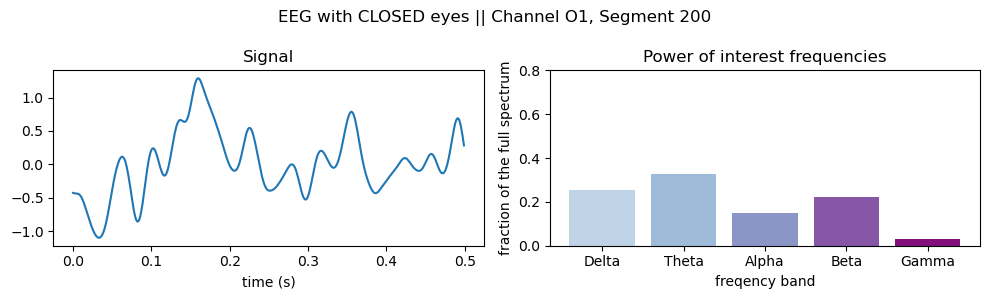

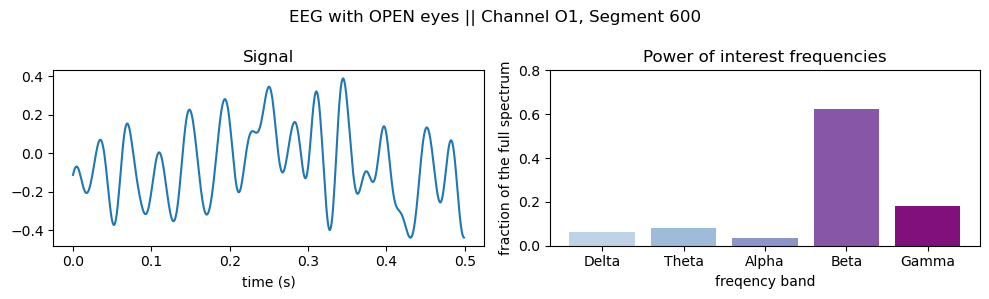

In [20]:
# Skip this
# function to display a segment and its power spectrum band powers
def disp_segment_v2(channel='Fp1', num=10):
    channel_data = data_segmented['Fp1']
    segment = np.array(channel_data.iloc[num][:-1])
    time = np.linspace(0, 0.5, int(fs/2), endpoint=False)
    label = data_segmented[channel]['label'][num]

    psd, band_names = getBandPower(segment, fs)

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(f"EEG with {'CLOSED' if label == 1 else 'OPEN'} eyes || Channel {channel}, Segment {num}")
    axes[0].plot(time, segment)
    axes[0].set_xlabel('time (s)')
    axes[0].set_title("Signal")
    axes[1].bar(band_names, psd, color=['#bfd3e6', '#9ebcda', '#8c96c6', '#8856a7', '#810f7c'])
    axes[1].set_xlabel('freqency band')
    axes[1].set_ylabel('fraction of the full spectrum')
    axes[1].set_ylim([0, 0.8])
    axes[1].set_title("Power of interest frequencies")
    plt.tight_layout()
    plt.show()

disp_segment_v2(channel='O1', num = 200)
disp_segment_v2(channel='O1', num = 600)

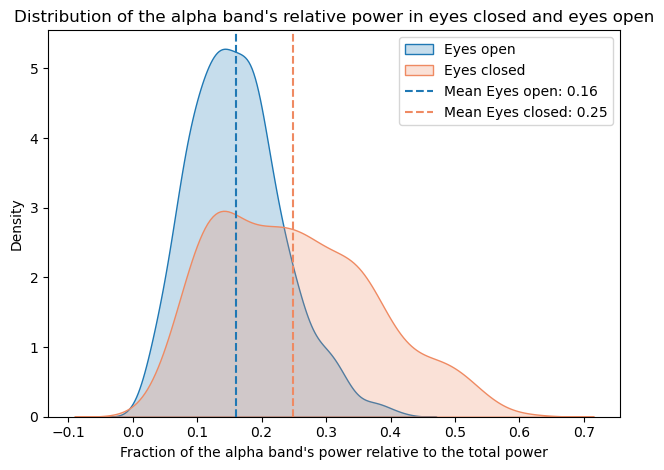

In [24]:
# Skip this
# function to display, for a given channel the difference in distribution of
# the values for the power of the alpha band for eyes closed and eyes open
def channel_alpha_dist_v2(channel='P1'):
    channel_data = data_segmented[channel]

    data_open = channel_data.loc[channel_data['label']==0]
    data_closed = channel_data.loc[channel_data['label']==1]

    # values of the alpha band's power in eyes closed and eyes open
    eo = [getBandPower(data_open.iloc[i,:-1], fs)[0][2] for i in range(len(data_open))]
    ec = [getBandPower(data_closed.iloc[i,:-1], fs)[0][2] for i in range(len(data_closed))]
    mean_eo = np.mean(eo)
    mean_ec = np.mean(ec)

    # plot pdf approximations
    sns.kdeplot(eo, color='#1f78b4', label='Eyes open', fill=True)
    sns.kdeplot(ec, color='#ef8a62', label='Eyes closed', fill=True)

    # Add vertical lines for means
    plt.axvline(x=mean_eo, color='#1f78b4', linestyle='--', label=f'Mean Eyes open: {mean_eo:.2f}')
    plt.axvline(x=mean_ec, color='#ef8a62', linestyle='--', label=f'Mean Eyes closed: {mean_ec:.2f}')

    # Add labels and title
    plt.xlabel("Fraction of the alpha band's power relative to the total power")
    plt.title("Distribution of the alpha band's relative power in eyes closed and eyes open")
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

channel_alpha_dist_v2('PO8')

In [23]:
# creating the feature space
channel_names = channels['names'].to_list()
dataset = pd.DataFrame()

# features for each channel
for channel_name in channel_names:
    channel_data = data_segmented[channel_name]
    seg_num = len(channel_data)

    # features: mean for each channel
    mean_df = pd.DataFrame({'mean_' + channel_name: channel_data.iloc[:,:-1].mean(axis=1)})
    dataset = pd.concat([dataset, mean_df], axis=1)
    #dataset['mean_' + channel_name] = channel_data.iloc[:,:-1].mean(axis=1)

    # features: standard deviation for each channel
    std_df = pd.DataFrame({'std_' + channel_name: channel_data.iloc[:,:-1].std(axis=1)})
    dataset = pd.concat([dataset, std_df], axis=1)
    #dataset['std_' + channel_name] = channel_data.iloc[:,:-1].std(axis=1)

    # features: kurtosis for each channel
    kurt_df = pd.DataFrame({'kurt_' + channel_name: channel_data.iloc[:,:-1].kurtosis(axis=1)})
    dataset = pd.concat([dataset, kurt_df], axis=1)
    #dataset['kurt_' + channel_name] = channel_data.iloc[:,:-1].kurtosis(axis=1)

    # features: peak to peak for each channel
    p2p_df = pd.DataFrame({'p2p_' + channel_name: channel_data.iloc[:,:-1].apply(np.ptp, axis=1)})
    dataset = pd.concat([dataset, p2p_df], axis=1)

    # features: power spectrum density for the several bands and ratios of these
    band_features = {'delta_'+channel_name: [],
                 'theta_'+channel_name: [],
                 'alpha_'+channel_name: [],
                 'beta_'+channel_name: [],
                 'gamma_'+channel_name: [],
                 'ratio1_'+channel_name: [], # t/d
                 'ratio2_'+channel_name: [], # a/t
                 'ratio3_'+channel_name: [], # b/a
                 'ratio4_'+channel_name: [], # g/b
                 'ratio5_'+channel_name: []} # (t+d)/(a+b)
    
    keys = list(band_features.keys())
    for i in range(seg_num):
        bands = getBandPower(channel_data.iloc[i,:-1], fs)[0]
        
        band_features[keys[0]] += [bands[0]]
        band_features[keys[1]] += [bands[1]]
        band_features[keys[2]] += [bands[2]]
        band_features[keys[3]] += [bands[3]]
        band_features[keys[4]] += [bands[4]]
        band_features[keys[5]] += [bands[1]/bands[0]]
        band_features[keys[6]] += [bands[2]/bands[1]]
        band_features[keys[7]] += [bands[3]/bands[2]]
        band_features[keys[8]] += [bands[4]/bands[3]]
        band_features[keys[9]] += [(bands[0] + bands[1])/(bands[2] + bands[3])]
        

    bands_df = pd.DataFrame(band_features)
    dataset = pd.concat([dataset, bands_df], axis=1)


# add the labels    
dataset['label'] = channel_data['label']
dataset

C:\Users\karul\AppData\Local\Temp\ipykernel_5560\158256149.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['label'] = channel_data['label']


,mean_Fp1,std_Fp1,kurt_Fp1,p2p_Fp1,delta_Fp1,theta_Fp1,alpha_Fp1,beta_Fp1,gamma_Fp1,ratio1_Fp1,...,theta_O2,alpha_O2,beta_O2,gamma_O2,ratio1_O2,ratio2_O2,ratio3_O2,ratio4_O2,ratio5_O2,label
0,-0.069462,0.541646,0.122572,2.841277,0.137420,0.176760,0.134050,0.426492,0.105293,1.286274,...,0.134407,0.281340,0.445397,0.072560,2.785526,2.093195,1.583127,0.162912,0.251341,1
1,-0.678891,0.632487,-0.512595,3.062890,0.155093,0.114275,0.220568,0.411537,0.067779,0.736816,...,0.075562,0.232715,0.485894,0.132793,2.598499,3.079790,2.087933,0.273297,0.145616,1
2,-1.571372,0.720570,-0.573020,2.919842,0.144299,0.151388,0.223430,0.377314,0.080346,1.049126,...,0.085233,0.254979,0.452319,0.154329,3.802146,2.991563,1.773944,0.341195,0.152199,1
3,1.405251,5.216725,-0.564858,15.747052,0.433598,0.494550,0.031058,0.021554,0.002377,1.140572,...,0.099937,0.267373,0.416262,0.088174,1.075856,2.675414,1.556860,0.211823,0.282062,1
4,2.456973,4.743005,-0.638163,15.434828,0.424760,0.512012,0.034808,0.016061,0.001555,1.205416,...,0.111353,0.203789,0.387646,0.218792,2.123486,1.830115,1.902190,0.564412,0.276940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,-0.097254,0.355089,-0.026546,1.670860,0.336777,0.387474,0.081173,0.125592,0.034124,1.150537,...,0.106887,0.173389,0.526631,0.116819,2.406564,1.622181,3.037272,0.221824,0.216138,0
1026,-0.208916,0.320793,0.349899,1.670860,0.230685,0.322316,0.203497,0.204800,0.011968,1.397213,...,0.106553,0.174113,0.494233,0.159469,2.757008,1.634050,2.838568,0.322659,0.217255,0
1027,-0.075422,0.210579,1.023667,1.177652,0.116195,0.255349,0.174105,0.402183,0.037169,2.197588,...,0.146516,0.211953,0.366580,0.211847,4.622590,1.446619,1.729536,0.577902,0.308041,0
1028,0.077865,0.159680,-0.716483,0.709407,0.141604,0.172475,0.236581,0.356723,0.068432,1.218007,...,0.038359,0.177137,0.497574,0.262047,19.664189,4.617879,2.808972,0.526650,0.059744,0


In [43]:
# Save the data in a pickle file to use later (skip if not needed)
with open('dataset_EEG.pkl', 'wb') as f:
    pd.to_pickle(dataset, f)

In [11]:
# Open the pickle file
with open('dataset_EEG.pkl', 'rb') as f:
    dataset = pd.read_pickle(f)

fs = 1024

<font size=5 color=#009999> <b>DIMENSIONALITY REDUCTION </b> <br>
FEATURE EXTRACTION OR FEATURE SELECTION
</font> <br> <br>

In [12]:
x = dataset.drop('label', axis=1)
y = dataset['label']

x_norm = (x - x.mean()) / x.std()

x = x_norm.values
y = y.values

Number of components for 95% variance: 198 (out of 896)


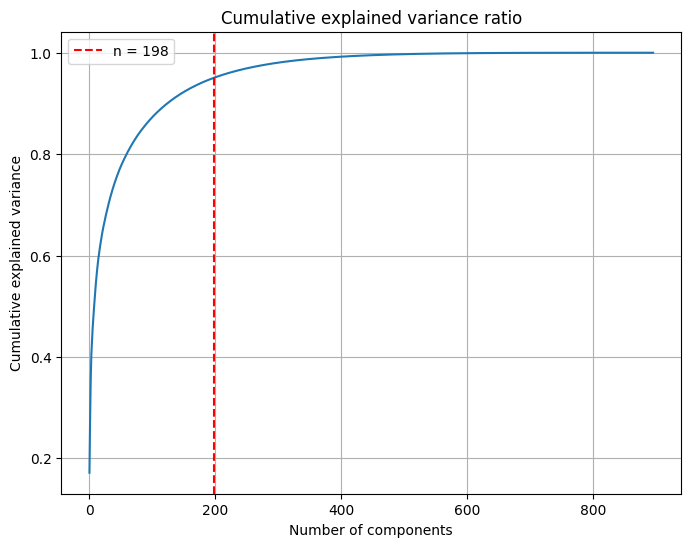

In [13]:
# Fit PCA with all components
pca = PCA()
pca.fit(x)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to explain 95% variance
n_components = np.where(cumulative_explained_variance > 0.95)[0][0] + 1

print(f"Number of components for 95% variance: {n_components} (out of {x.shape[1]})")

# Plot the explained variance ratio
plt.figure(figsize=(8,6))
plt.plot(cumulative_explained_variance)
plt.axvline(x=n_components, color='red', linestyle='--', label=f'n = {n_components}')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance ratio')
plt.legend()
plt.grid()
plt.show()

Variance explained by PC1: 0.17154454429797988 || Variance explained by PC2: 0.10240438700057278 || Variance explained the 2 PCs: 0.2739489312985527


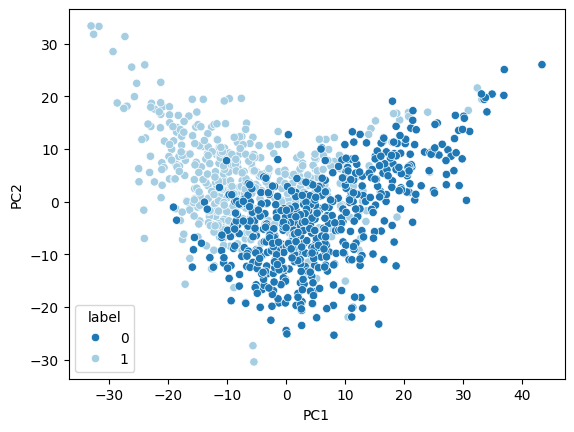

In [14]:
# Skip this
# just to vizualiza the data: plot it into the first two PCs to check linear separability in these two
pca = PCA(n_components=2)
pca = pca.fit(x)
var = pca.explained_variance_ratio_
print(f"Variance explained by PC1: {var[0]} || Variance explained by PC2: {var[1]} || Variance explained the 2 PCs: {sum(var)}")
pca = pca.transform(x)

pca = pd.DataFrame(pca, columns = ['PC1', 'PC2'])
pca['label'] = y

fig = sns.scatterplot(pca, x = 'PC1', y = 'PC2', hue = 'label', palette = ['#1f78b4', '#a6cee3'])

Variance explained by PC1: 0.17154454429797986 || Variance explained by PC2: 0.10240438700057286 || Variance explained by PC3: 0.08086398854365165 || Variance explained the 3 PCs: 0.3548129198422043


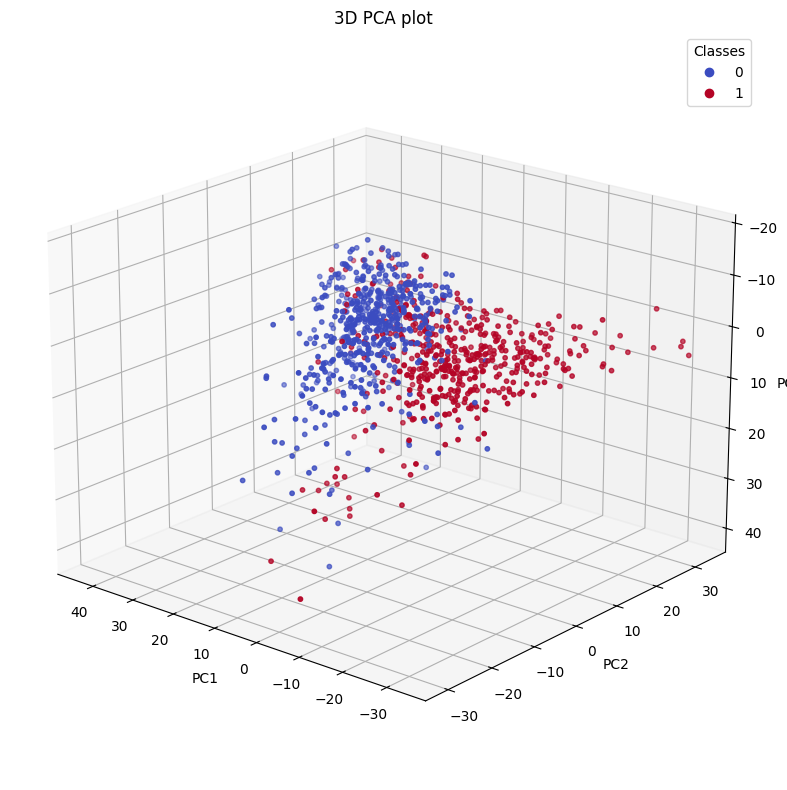

In [15]:
# Skip this
# Create a 3D PCA plot with PC1, PC2 and PC3
pca = PCA(n_components=3)
pca = pca.fit(x)
var = pca.explained_variance_ratio_
print(f"Variance explained by PC1: {var[0]} || Variance explained by PC2: {var[1]} || Variance explained by PC3: {var[2]} || Variance explained the 3 PCs: {sum(var)}")

pca = pca.transform(x)
pca = pd.DataFrame(pca, columns = ['PC1', 'PC2', 'PC3'])
pca['label'] = y

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA plot')
scatter = ax.scatter(pca['PC1'], pca['PC2'], pca['PC3'], c=pca['label'], cmap='coolwarm', s=10)
# To change the projection of the 3D plot, you can change the view_init values
ax.view_init(200, 50)
plt.legend(*scatter.legend_elements(), title='Classes')
plt.tight_layout()
plt.show()

In [18]:
# apply pca dimensionality reduction by keeping only the previously computed first n_components explaing 95% variance
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca, columns=[f'PC{i+1}' for i in range(n_components)])
x_pca['label'] = y

print("Shape of the PCA transformed data: ", x_pca.shape)
print("Shape of original data: ", x.shape)
x_pca.head()



Shape of the PCA transformed data:  (1030, 199)
Shape of original data:  (1030, 896)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC190,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,label
0,4.966854,3.102136,-4.526389,-2.429068,1.557205,-1.908021,1.847831,1.760083,-1.421636,-0.065126,...,0.358392,-0.237516,0.059991,-0.338784,-0.710374,-0.114603,-0.090348,0.055564,0.236118,1
1,6.128933,3.610531,-4.431473,-2.899812,5.256349,-0.708073,-1.647563,-1.295577,-0.687690,5.068613,...,0.845269,-0.109138,0.647949,-0.355239,-0.671860,0.068958,-0.532712,0.635004,0.191498,1
2,3.886561,3.065600,-3.475736,-1.848720,7.873324,3.696926,-1.761823,2.325411,0.756582,1.270845,...,0.625586,0.172033,1.114155,0.114633,-0.076936,0.535746,-0.311475,1.087162,-0.053050,1
3,30.861169,17.313203,10.032523,-6.893376,-7.674323,6.359105,-0.833334,0.294287,4.326952,-1.746258,...,0.575622,0.855490,0.472225,-0.318276,1.169725,-0.608889,-0.466543,-0.395840,0.230936,1
4,32.394313,21.570882,14.064970,-8.456858,-8.924337,3.365348,1.737073,-7.487998,6.582868,2.802659,...,-0.285049,0.338767,-0.309649,-0.226930,0.735692,0.243339,-0.814460,-0.243758,-0.299228,1


<br><br>

<font size=6 color=#009999> <center><b>PART III - CLASSIFICATION </b></center> </font> <br> <br>

<font size=5 color=#009999> <b>MODEL AND HYPERPARAMETERS SELECTION </b> <br>

In [19]:
# Neural Netwrok
# functions to train and evaluate the model
def train_model(X_train, Y_train):
    # define decaying learning rate (exponencial)
    initial_learning_rate = 0.0004
    decay_steps = 40 # number of steps for the decay to be applied once
    decay_rate = 0.2
    lr_scheduler = LearningRateScheduler(lambda epoch: initial_learning_rate * np.power(decay_rate, epoch / decay_steps))

    input_dim = X_train.shape[1]
    model = Sequential()
    model.add(Dense(units=256, input_dim = input_dim, activation='relu', kernel_initializer="random_normal", bias_initializer="random_normal"))
    model.add(Dense(units=64, activation='relu', kernel_initializer="random_normal", bias_initializer="random_normal"))
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer="random_normal", bias_initializer="random_normal"))

    # Compile and fit the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), loss='binary_crossentropy', metrics=['accuracy']) #0.0001
    history = model.fit(x=X_train, y=Y_train, epochs=40, batch_size=32, callbacks=[lr_scheduler], verbose=0)

    return model

def predict(model, X_test):
    # prediction on the test data 
    y_pred_prob = model.predict(X_test, verbose=0)

    # Convert values above threshold to 1, and values below threshold to 0
    threshold = 0.5
    Y_pred = (y_pred_prob > threshold).astype(int)
    return Y_pred

def evaluate_model(model, X_test, Y_test):
    # prediction on the test data 
    Y_pred = predict(model, X_test)

    # performance metrics
    test_accuracy = accuracy_score(Y_test, Y_pred)
    print('###################################################')
    print(f'###### Test accuracy = {test_accuracy} ######')
    print('###################################################')
    
    return test_accuracy, Y_pred

# Calculate the amount of parameters in the model
#def count_parameters(model):
#    return sum(tf.keras.backend.count_params(p) for p in model.trainable_variables)

#print(f"Number of parameters in the model: {count_parameters(m)}")


In [43]:
### Gradient boosting ensemble classifier

from sklearn.ensemble import GradientBoostingClassifier

def train_model(X_train, Y_train):
    model = GradientBoostingClassifier(learning_rate=0.1, max_depth=6, max_features='sqrt', min_samples_leaf=4, min_samples_split=3, n_estimators=100, random_state=42)
    model.fit(X_train, Y_train)
    return model

def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f'###### Test accuracy = {accuracy} ######')
    return accuracy, Y_pred
    

In [41]:
### KNN classifier

from sklearn.neighbors import KNeighborsClassifier

def train_model(X_train, Y_train):
    model = KNeighborsClassifier(n_neighbors=20, metric='euclidean', weights='distance')
    model.fit(X_train, Y_train)
    return model

def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f'###### Test accuracy = {accuracy} ######')
    return accuracy, Y_pred

In [45]:
### Decision Tree

from sklearn.tree import DecisionTreeClassifier

def train_model(X_train, Y_train):
    model = DecisionTreeClassifier(criterion='log_loss', min_samples_split=4, min_samples_leaf=1, max_depth=16)
    model.fit(X_train, Y_train)
    return model

def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f'###### Test accuracy = {accuracy} ######')
    return accuracy, Y_pred

In [55]:
### SVM

from sklearn.svm import SVC

def train_model(X_train, Y_train):
    model = SVC(C=0.2, kernel='rbf', gamma='scale')
    model.fit(X_train, Y_train)
    return model

def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f'###### Test accuracy = {accuracy} ######')
    return accuracy, Y_pred

<font size=5 color=#009999> <b>MODEL EVALUATION</b> <br>


In [20]:
# define the data and convert it into numpy arrays for tensorflow
X = x_pca.drop('label', axis=1)
Y = x_pca['label']

X = X.values
Y = Y.values

# split data into validation and test sets
X_val, X_test, Y_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# internal validation
accuracies = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Iterate over each fold
for fold_idx, (train_index, eval_index) in enumerate(kf.split(X_val)):
    print(f"Fold {fold_idx + 1}:")
    X_train, X_eval = X_val[train_index], X_val[eval_index]
    Y_train, Y_eval = Y_val[train_index], Y_val[eval_index]

    # training and testing
    m = train_model(X_train, Y_train)
    acc, _ = evaluate_model(m, X_eval, Y_eval)
    accuracies += [acc]

# performance on the test set
m = train_model(X_val, Y_val)
acc_test, _ = evaluate_model(m, X_test, Y_test)

## metrics
print('#####################################################################')
print(f'# Estimated accuracy from K-fold cross validation: {np.mean(accuracies)}')
print(f'# Accuracy on the test set: {acc_test}')

Fold 1:
###################################################
###### Test accuracy = 0.9518072289156626 ######
###################################################
Fold 2:
###################################################
###### Test accuracy = 0.963855421686747 ######
###################################################
Fold 3:
###################################################
###### Test accuracy = 0.9759036144578314 ######
###################################################
Fold 4:
###################################################
###### Test accuracy = 1.0 ######
###################################################
Fold 5:
###################################################
###### Test accuracy = 0.975609756097561 ######
###################################################
Fold 6:
###################################################
###### Test accuracy = 0.9634146341463414 ######
###################################################
Fold 7:
###########################################